# DFT calculated energies

#### Imports

In [2]:
import sys
import os
import time
import warnings
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import xgboost as xgb

warnings.simplefilter(action='ignore', category=FutureWarning)

from ase.db import connect
from skopt import gp_minimize
from tqdm.notebook import tqdm
from collections import Counter
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

sys.path.append('../scripts')
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect
from ase.visualize import view

DFT_folder = "../DFT_data/"
db_folder = "../DFT_data/"

# The COOH Pt data is in "single_element_COOH_C_adsorbed_out.db"
db_name_SE_COOH = "single_element_COOH_C_adsorbed_out.db"
# THe H data is in "single_element_H_out.db"
db_name_SE_H = "single_element_H_out.db"
db_name_SE = "single_element_slabs_out.db"

sys.path.append('../scripts')
features_folder = "../csv_features/"

# Now you can import the learning_curve function from functions.py
#from functions import single_parity_plot, learning_curve, pandas_to_DMatrix, mixed_site_vector, hollow_site_vector, on_top_site_vector, predict_G, precompute_binding_energies_SPEED, precompute_binding_energies_TQDM, create_surface, initialize_surface, predict_mixed_energies, calc_given_energies, simulate_loss_diagonal, simulate_loss_both_corners, simulate_loss_left_corner, simulate_loss_right_corner, deltaEdeltaE_plot, sort_energies, metals_in_good_hollow_sites_plot, Bayesian_optimization_plot, Bayesian_optimization, plot_pure_metals, load_G_models, AB_to_split, make_long_vector, initialize_swim_surface
from functions import * # Angry people on GitHub claim that this is bad, but I want to import all function and this does that. The namespace don't overlap with any common functions, or eachother, so I should be safe from the common pitfalls

In [3]:
# Load binding energy (G) prediction models for COOH, H and H+COOH mixed

models = load_G_models()
corrections = load_corrections()

In [5]:
models

{'H': <xgboost.core.Booster at 0x106475e70>,
 'COOH': <xgboost.core.Booster at 0x1065dec50>,
 'mixed': <xgboost.core.Booster at 0x106274dc0>,
 'OH': <xgboost.core.Booster at 0x1065de5c0>,
 'O': <xgboost.core.Booster at 0x1065deb60>}

In [4]:
corrections

{'H_COOH': 0.74,
 'COOH': 0.4950000000000001,
 'H': 0.245,
 'OH': 0.3150000000000001,
 'O': 0.030000000000000054}

In [5]:
# Specify metal colors
metal_colors = dict(Pt = '#babbcb',
                    Pd = '#1f8685',
                    Ag = '#c3cdd6',
                    Cu = '#B87333',
                    Au = '#fdd766')

#### Chan numbers - DO I NEED TO HAVE THEM HERE? CAN'T THEY JUST BE IN FUNCTIONS.PY? TEST

In [6]:
# Free (eV)
CO2   = {"ZPE": 0.31, "CpdT": 0.10, "minusTS": -0.66, "TS": 0.66}
CO    = {"ZPE": 0.13, "CpdT": 0.09, "minusTS": -0.61, "TS": 0.61}
H2    = {"ZPE": 0.28, "CpdT": 0.09, "minusTS": -0.40, "TS": 0.40}
H2O   = {"ZPE": 0.57, "CpdT": 0.10, "minusTS": -0.67, "TS": 0.67}
HCOOH = {"ZPE": 0.90, "CpdT": 0.11, "minusTS": -0.99, "TS": 0.99}
#Slab = {"ZPE": 0.00, "CpdT": 0.00, "minusTS": -0.00} #Holy moly, den her overskrev Slab funktionen

# *Bound to the surface (eV)
# Bidentate *OOCH?
bound_CO   = {"ZPE": 0.19, "CpdT": 0.08, "minusTS": -0.16, "TS": 0.16}
bound_OH   = {"ZPE": 0.36, "CpdT": 0.05, "minusTS": -0.08, "TS": 0.08}
bound_OCHO = {"ZPE": 0.62, "CpdT": 0.11, "minusTS": -0.24, "TS": 0.24} #Either bidentate or monodentate. Use for both for now
bound_O    = {"ZPE": 0.07, "CpdT": 0.03, "minusTS": -0.04, "TS": 0.04}
bound_COOH = {"ZPE": 0.62, "CpdT": 0.10, "minusTS": -0.19, "TS": 0.19}
bound_H    = {"ZPE": 0.23, "CpdT": 0.01, "minusTS": -0.01, "TS": 0.01}

# Approximation Factors (FA)
AF = {"CO2": CO2, "CO": CO, "H2": H2, "H2O": H2O, "HCOOH": HCOOH, \
      "bound_CO": bound_CO, "bound_OH": bound_OH, "bound_OCHO": bound_OCHO, \
      "bound_O": bound_O, "bound_COOH": bound_COOH, "bound_H": bound_H}

# This is from the molecules_out.db file
molecules_dict = {'CO': -12.848598765234707,\
 'CO2': -19.15168636258064,\
 'CH2O2': -25.7548327798152,\
 'C2H4O2': -41.95993780269195,\
 'H2': -6.67878491734772,\
 'H2O': -12.225511685485456,\
 'CH2O': -19.92286258910958,\
 'CH4O': -27.652189372849637,\
 'C2H6O': -43.67355392866396,\
 'C2H2O2': -32.92328015484662,\
 'C2H2O4': -44.117581976029946}

#### Plotting

#### Fetching DFT data - PUT THIS IN A FUNCTION

In [6]:
SE_COOH_metals = []
SE_COOH_energies = []

with connect(f'{DFT_folder}{db_name_SE_COOH}') as db_COOH:
    for row_slab in db_COOH.select('energy'):
        SE_COOH_energies.append(row_slab.energy)
        SE_COOH_metals.append(row_slab.formula[0:2])

SE_H_metals = []
SE_H_energies = []

with connect(f'{DFT_folder}{db_name_SE_H}') as db_H:
    for row_slab in db_H.select('energy'):
        SE_H_energies.append(row_slab.energy)
        SE_H_metals.append(row_slab.formula[0:2])
           
SE_slab_metals = []
SE_slab_energies = []

with connect(f'{DFT_folder}{db_name_SE}') as db_slab:
    for row_slab in db_slab.select('energy'):
        SE_slab_energies.append(row_slab.energy)
        SE_slab_metals.append(row_slab.formula[0:2])

#### Subtracting the slabs

In [7]:
### Summing up all the Approximation Factors for COOH
ZpE_sum  = AF["bound_COOH"]["ZPE"]  - AF["HCOOH"]["ZPE"]  + 1/2*AF["H2"]["ZPE"]
CpdT_sum = AF["bound_COOH"]["CpdT"] - AF["HCOOH"]["CpdT"] + 1/2*AF["H2"]["CpdT"]
TS_sum   = AF["bound_COOH"]["TS"]   - AF["HCOOH"]["TS"]   + 1/2*AF["H2"]["TS"] #Figure the signs out
correction_constant_COOH = ZpE_sum + CpdT_sum - TS_sum

### Summing up all the Approximation Factors for H
ZpE_sum  = AF["bound_H"]["ZPE"]  - 1/2 * AF["H2"]["ZPE"] # Stokiometrien er bevaret! Tak, Oliver
CpdT_sum = AF["bound_H"]["CpdT"] - 1/2 * AF["H2"]["CpdT"]
TS_sum   = AF["bound_H"]["TS"]   - 1/2 * AF["H2"]["TS"]
correction_constant_H = ZpE_sum + CpdT_sum - TS_sum

#DeltaE_COOH = np.array(SE_COOH_energies) - np.array(SE_slab_energies) - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]
#DeltaE_H = np.array(SE_H_energies) - np.array(SE_slab_energies) - 1/2*molecules_dict["H2"]

# Hvis de skal passe ind i plottet, så skal de refereres tilbage til HCOOH - H (Man trækker 1/2 H2 fra)
DeltaE_COOH = np.array(SE_COOH_energies) - molecules_dict["CH2O2"] + 1/2*molecules_dict["H2"] - np.array(SE_slab_energies)
DeltaE_H    = np.array(SE_H_energies) - np.array(SE_slab_energies) - 1/2*molecules_dict["H2"]

#Nu skal de korrigeres til deltaG i stedet for elektroniske energier deltaE
DeltaG_COOH = DeltaE_COOH + correction_constant_COOH
DeltaG_H    = DeltaE_H    + correction_constant_H

pure_metal_info = {"DeltaG_H": DeltaG_H, "DeltaG_COOH": DeltaG_COOH, "SE_slab_metals": SE_slab_metals}

In [8]:
### Summing up all the Approximation Factors for COOH
ZpE_sum  = AF["bound_COOH"]["ZPE"]  - AF["HCOOH"]["ZPE"]  + 1/2*AF["H2"]["ZPE"]
print("ZpE_sum: ", ZpE_sum)
CpdT_sum = AF["bound_COOH"]["CpdT"] - AF["HCOOH"]["CpdT"] + 1/2*AF["H2"]["CpdT"]
print("CpdT_sum: ", CpdT_sum)
TS_sum   = AF["bound_COOH"]["TS"]   - AF["HCOOH"]["TS"]   + 1/2*AF["H2"]["TS"] #Figure the signs out
print("-TS_sum: ", -TS_sum)
correction_constant_COOH = ZpE_sum + CpdT_sum - TS_sum
print(f"Correction constant from E to G for COOH: {correction_constant_COOH:.4f}\n")

### Summing up all the Approximation Factors for H
ZpE_sum  = AF["bound_H"]["ZPE"]  - 1/2 * AF["H2"]["ZPE"]
print("ZpE_sum: ", ZpE_sum)
CpdT_sum = AF["bound_H"]["CpdT"] - 1/2 * AF["H2"]["CpdT"]
print("CpdT_sum: ", CpdT_sum)
TS_sum   = AF["bound_H"]["TS"]   - 1/2 * AF["H2"]["TS"]
print("-TS_sum: ", -TS_sum)
correction_constant_H = ZpE_sum + CpdT_sum - TS_sum
print(f"Correction constant from E to G for H:    {correction_constant_H:.4f}")

ZpE_sum:  -0.14
CpdT_sum:  0.035
-TS_sum:  0.6000000000000001
Correction constant from E to G for COOH: 0.4950

ZpE_sum:  0.09
CpdT_sum:  -0.034999999999999996
-TS_sum:  0.19
Correction constant from E to G for H:    0.2450


In [9]:
#Ref *COOH til CO2 og 1/2 H2 (g)

In [10]:
CO2_rel = - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]
print(f"Relating the energies back to CO2 plus 1/2 H2:    {CO2_rel:.2f}")
HCOOH_rel = - molecules_dict["CH2O2"] + 1/2*molecules_dict["H2"]
print(f"Relating the energies back to HCOOH minus 1/2 H2: {HCOOH_rel:.2f}")

Relating the energies back to CO2 plus 1/2 H2:    22.49
Relating the energies back to HCOOH minus 1/2 H2: 22.42


#### Plotting energies from single elements

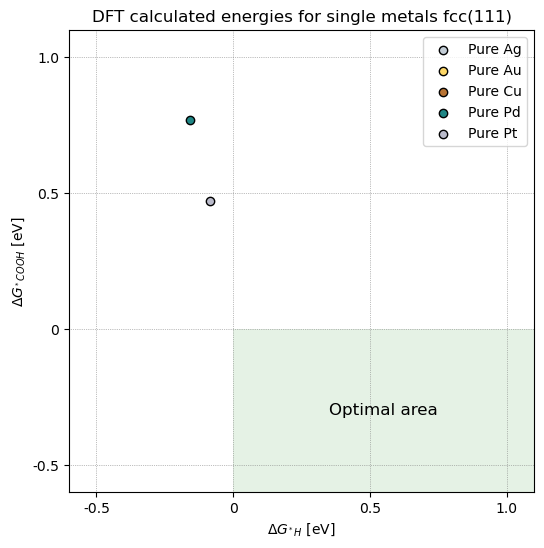

In [11]:
plot_pure_metals(SE_slab_metals, DeltaG_H, DeltaG_COOH, metal_colors)

### Plotting predicted energies from custom surface

In [12]:
# Maybe I should have a smart kind of plot, where, when you hover over it, it shows the xy coordinates and you can go check what it looks like. I even have a function from the swimming ring thing that can plot nice circles from a 2by2 surface
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
## This routine includes: 

# Initialize a surface from a given stochiometry
dim_x, dim_y, split = 200, 200, [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]

surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates + mixed_sites
surface = precompute_binding_energies_SPEED(surface, dim_x, dim_y, models)

#### Sort the energies into piles that come from the same top-site metal

The \*COOH adsorbates sit on top-sites, where a single atom is the primary influence on the binding energy. They are surrounded by \*H adsorbates in hollow-sites, where three atoms are the primary influence on the binding energy.

In the following plot, two energies have to be paired. All pairs between on-top site and hollow site will be plotted. This will result in 3 points per on-top site, one with each neighbour.

Uhh jeg kunne sortere alle hollow sites der ligger godt energi-mæssigt fra og lave plots over hvilke metaller der er rundt om dem. Måske ville man opdage, at det typisk er Pt, Ag-sites? Something, something, baderinge.

Der er garanteret andre måder at plotte ting på.

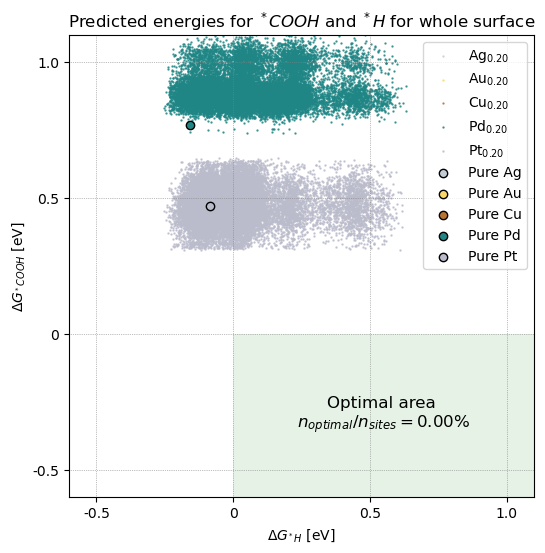

In [13]:
experiment_name = "test_SPEED"
reward_type = "right_corner"
deltaEdeltaE_plot(experiment_name, surface, pure_metal_info, reward_type, show_plot = True)

#### Plotting energies from optimal swim ring surface

I'll try the following surfaces:

Optimal top layer structure - with most possible swim rings

Bottom two layers random distribution of A and B with the 1 to 6 mixture. 1 part A, 6 parts B

In [14]:
#### I SHOULD MAKE ALL THE SAME COMBINATIONS AS IN THE DFT DATA? YEAH AND THEN I COULD USE THE NEW MODEL
A = ["Pd", "Pt"]
B = ["Au", "Ag"]

# Make a surface with swim rings
surface = initialize_swim_surface(A, B)

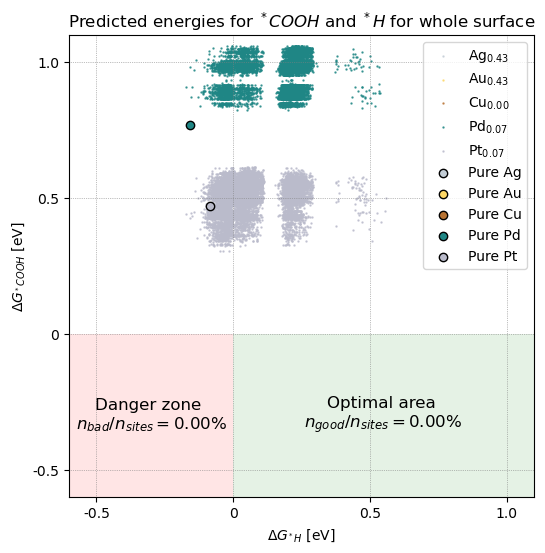

In [15]:
experiment_name = "test_swim_ring"
reward_type = "both_corners"
deltaEdeltaE_plot(experiment_name, surface, pure_metal_info, reward_type, show_plot = True)

What does this show?

The "optimal bad hollow sites" were hoped to have a negative binding energy for COOH and a positive binding energy for H. It turns out the model predicts: COOH doesn't bind, H binds.

#Er det ikke sådan, at hvis COOH har en bindingsenergi på -0.12 eV, så får man den optimale energi ud? Og hvornår er det sådan, at man ikke længere får noget energi ud?

#Hvor mange gode sites skal der til, før det er godt?

Man kan ikke både få ingen punkter i danger zone og optimal area, pga. de der bands. Skal man bare acceptere at nogle sites vil lave CO og så prøve at få så mange optimale sites som muligt?

#Could I make a shader map, that values each site in terms of how good a contribution it would make?

A map that the energy plane is multiplied by and them summed for a goodness score. Probably will be better and better closer to E(COOH)=-0.12 eV. Would it be exponentially better closer to the optimal energy?

Hvordan ville det reward map se ud?

Lav en god model for det. Lav en funktion, som kan vurdere en matrice med energier ift. reward map og summe godheden. Det kan så bruges i en stor fed BO runde med kæmpe præcision, så den kan ramme helt rigtigt. Men der er self også 0.05 eV MAE på modellerne, så tættere kommer vi heller ikke. Hvis man ender med kun 3-4 metaller brugt kunne man måske lave ny data med kun de fire for at få bedre accuracy. Men hvis end-result er, at man prøver i laboratoriet at blande præcist den fraction som BO gætter på, så er der nok ikke uendelig præcision i blandingen der heller, og en lille afstand i stochiometrisk afstand gør nok heller ikke noget.

ONSDAG TO DO: Research og tegn et shader reward map, som er accurate


## Bayesian Optimization - Best composition for $n_{optimal}$

In [28]:

#from skopt.space import Space
#from skopt.utils import normalize_dimensions

experiment_name = "test"

# Define the Search Space
space = [(0.0, 1.0)] * 5
# AuPt space
AuPt_space = [(0.0, 0.00001), (0.0, 1.0), (0.0, 0.00001), (0.0, 0.00001), (0.0, 1.0)]
n_calls = 10

def Bayesian_optimization(space, simulate_loss_type):
    ## Normalize the search space dimensions
    #space = normalize_dimensions(space)

    # Initialize the Bayesian Optimizer
    optimizer = gp_minimize(
        simulate_loss_type,
        space,
        n_calls = 10, # Number of evaluations of the loss function
        random_state=42, # Set a random seed for reproducibility
        n_jobs = 1)

    # Retrieve the intermediate results
    results = optimizer.x_iters
    losses = optimizer.func_vals

    # Print the intermediate results
    for i, result in enumerate(results):
        loss = losses[i]
        print(f"Iteration {i+1}: Surface Stochiometry: {result}, Loss: {loss}")

    # Retrieve the optimal solution
    optimal_surface_stochiometry = optimizer.x
    optimal_loss = optimizer.fun  # Negate the loss to retrieve the maximized value

    print("Optimal Surface Stochiometry:", optimal_surface_stochiometry)
    print("Optimal Loss:", optimal_loss)
    return results, losses, optimal_surface_stochiometry

results, losses, optimal_surface_stochiometry = Bayesian_optimization(space, simulate_loss_diagonal)

Iteration 1: Surface Stochiometry: [0.7965429868602331, 0.18343478986616382, 0.7796910002727695, 0.5968501579464871, 0.44583275285359125], Loss: -1306
Iteration 2: Surface Stochiometry: [0.09997491581800291, 0.45924889196586727, 0.3337086111390219, 0.1428668179219408, 0.650888472948853], Loss: -2028
Iteration 3: Surface Stochiometry: [0.05641157902710027, 0.7219987722668249, 0.9385527090157504, 0.0007787658410143285, 0.9922115592912177], Loss: -2305
Iteration 4: Surface Stochiometry: [0.6174815096277166, 0.611653160488281, 0.007066305219717408, 0.02306242504141576, 0.5247746602583893], Loss: -3947
Iteration 5: Surface Stochiometry: [0.3998609717152556, 0.046665663213615434, 0.9737555188414594, 0.23277134043030429, 0.09060643453282081], Loss: -425
Iteration 6: Surface Stochiometry: [0.6183860093330874, 0.38246199126716285, 0.9832308858067884, 0.46676289324798004, 0.8599404067363208], Loss: -1875
Iteration 7: Surface Stochiometry: [0.6803075385877798, 0.4504992519695431, 0.01326496115986

RIGHT CORNER:
From 100by100 100its results:
Optimal Surface Stochiometry: [1.0, 1.0, 0.0, 1.0, 0.7756340795658901]
Optimal Loss: 150

From 140by140 50 its result:
Optimal Surface Stochiometry: [0.8953318995954538, 0.738086071173332, 0.0, 0.5932504594623, 0.5487552835398027]
Optimal Loss: 294

From 140by140 100 its result:
Optimal Surface Stochiometry: [0.8458380615695716, 1.0, 0.0, 0.5242110298660663, 0.689633397655569]
Optimal Loss: 301

DIAGONAL:
Optimal Surface Stochiometry: [1.0, 1.0, 0.0, 0.0, 0.6098243992113722]
Optimal Loss: 2111

LEFT CORNER:
Optimal Surface Stochiometry: [0.05641157902710027, 0.7219987722668249, 0.9385527090157504, 0.0007787658410143285, 0.9922115592912177]
Optimal Loss: -17

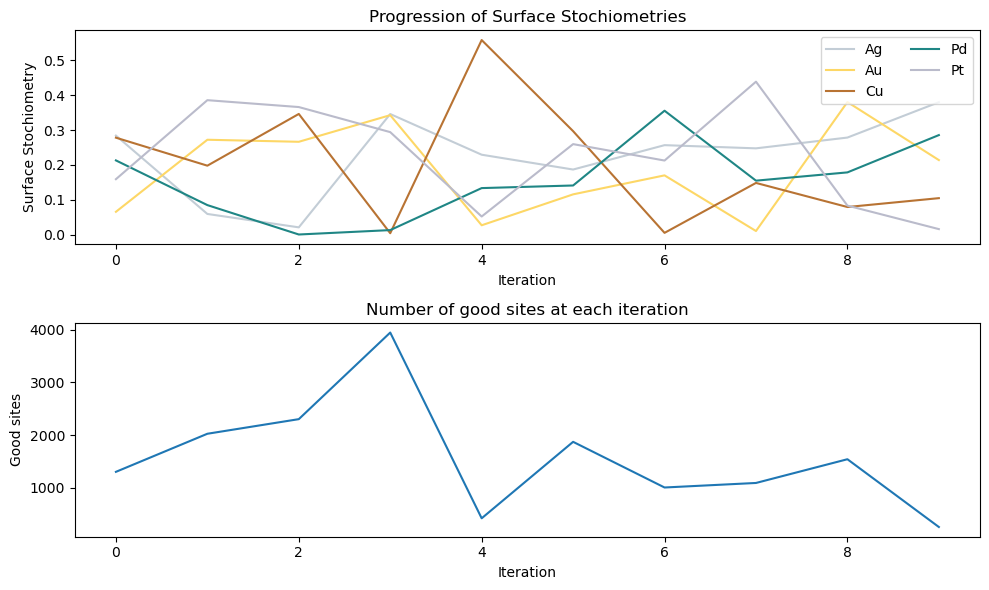

In [29]:
## I would like a plot that shows the progression in the predicted stochiometries and the resulting losses

Bayesian_optimization_plot(results, losses, experiment_name)

It seems there is a lot of variation even on borderline the same stochiometry. That is probably no good, but there has to be a tradeoff between number of iterations and precision. 

Maybe the plot should show the best guess stochiometry

at 100by100 there is still variation, maybe I should go for a bit larger surface? So it can dial in the finer details

140by140 is about double the size of 100by100, which kind of makes sense because of sqrt(2).

Try another loss function! That rewards binding COOH better and H worse in general. Points awarded for going down right Maybe points for going under the diagonal?

It's really hard to squish that many points in the lower right corner.

I could do the final "measuring" on a really large surface to get an accurate percentage

I should show the before/after of optimizing for dots in the lower right corner/under the diagonal etc.

Maybe I should try some optimizations without Cu in the mix, since it seems like the BO hates Cu. But I guess it finds out all by itself. But I guess Cu might be fine in the diagonal case. Also think about the logic behind the diagonal case. What does it mean to be on the diagonal? 
On the diagonal: COOH and H binds equally well.
Under the diagonal: COOH binds better than H.
With a larger voltage, COOH binds better and H worse. 

A comparison between a non-optimized deltaE/deltaE-plot and an optimized with BO-one would be cool. Then the tiny improvements could be shown.

Maybe I should look at the span of the stochiometries, that all result in almost optimal (at least the best found). Are they almost similar?

I could make a sliding change in the deltaE/deltaE-plot from the standard even distribution to the optimized stochiometry and plot them as a gif. This would show the efforts to move the energies towards the desired area.

I could make occupancy plots with the unoptimized and optimized stochiometries. 

If I make an optimization of just the three metals that is seen to actually do something, then I could make a 2D triangle plot of the stochiometries tried and where the optimal zone is. But it might not be so important, if the corner is the most important part. Holy guac tho, not much is possible to push down there. Maybe that's why it's so hard to get the catalyst to work. 

Argument for at man godt kan bruge BOGP: "The idea is to approximate the function using a Gaussian process. In other words the function values are assumed to follow a multivariate gaussian." Det lader jo også til, at når man ændrer lidt i kompositionen så ændrer man bare nogle få sites, og der ændrer loss'et en lille smule. Om det svarer til en multivariate gaussian er ikke sikkert, men små ændringer i input skulle gerne give små ændringer i output.

I wonder what would happen, if I tried to get BO to find the best surface only using Pt and Au. There is some logic behind the swim rings idea, but from the BO it looks like more metals are needed to tailor the energies more precisely.

Maybe show what would happen in the four corners:
Upper left: COOH binds too late, overpotential is needed. H binds too well, but would probs be removed by the potential needed to put COOH on. 
Lower left: Both COOH and H binds on V=0. Risk of CO creation.
Upper right: Neither COOH nor H binds at V=0.
Lower right: COOH binds before V=0 and H doesn't - Yay!

Maybe I should make a BO where I reward the BO for limiting the number of points in the lower left corner, as this would seem to be the danger zone. 

### Gif that shows improvements in "optimal energies" with Bayesian Optimization with Gaussian Processes

In [ ]:
reward_type = "corner"
dim_x, dim_y, metals = 140, 140, ['Ag', 'Au', 'Cu', 'Pd', 'Pt']

even_split_stoch = [0.2, 0.2, 0.2, 0.2, 0.2]
optimal_stoch = {"corner": [0.8458380615695716, 1.0, 0.0, 0.5242110298660663, 0.689633397655569], "diagonal": [1.0, 1.0, 0.0, 0.0, 0.6098243992113722]}

#Linear interpolation between two 5D points
num_interpolations = 58  # Number of interpolated points
interpolated_points = linear_interpolation(even_split_stoch, optimal_stoch[reward_type], num_interpolations)
for i, split in tqdm(enumerate(interpolated_points)):
    split = np.array(split)/np.sum(split)
    stochiometry = dict(zip(metals, split))
    surface = initialize_surface(dim_x, dim_y, metals, split)
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)

    E_top_dict, E_hol_dict, n_ratio, n_good, good_hol_sites = sort_energies(surface, reward_type)
    deltaEdeltaE_plot("Gif_corner/"+str(i), E_hol_dict, E_top_dict, SE_slab_metals, reward_type, show_plot = False)

In [ ]:
reward_type = "diagonal"
dim_x, dim_y, metals = 140, 140, ['Ag', 'Au', 'Cu', 'Pd', 'Pt']

even_split_stoch = [0.2, 0.2, 0.2, 0.2, 0.2]
optimal_stoch = {"corner": [0.8458380615695716, 1.0, 0.0, 0.5242110298660663, 0.689633397655569], "diagonal": [1.0, 1.0, 0.0, 0.0, 0.6098243992113722]}

#Linear interpolation between two 5D points
num_interpolations = 60  # Number of interpolated points
interpolated_points = linear_interpolation(even_split_stoch, optimal_stoch[reward_type], num_interpolations)
for i, split in tqdm(enumerate(interpolated_points)):
    split = np.array(split)/np.sum(split)
    stochiometry = dict(zip(metals, split))
    surface = initialize_surface(dim_x, dim_y, metals, split)
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)

    E_top_dict, E_hol_dict, n_ratio, n_good, good_hol_sites = sort_energies(surface, reward_type)
    deltaEdeltaE_plot("Gif_diagonal/"+str(i), E_hol_dict, E_top_dict, SE_slab_metals, reward_type, show_plot = False)

In [7]:
## Stitch together the images
import imageio

for reward_type in ["corner", "diagonal"]:
    images = []
    for filename in ["../figures/DFT_calc_energies/Gif_"+reward_type+"/"+str(n)+".png" for n in range(60)]:
        images.append(imageio.imread(filename))
    imageio.mimsave("../figures/DFT_calc_energies/Gif_"+reward_type+"/Såerdergif.gif", images, duration = 0.1, transparent=True)

/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_983/207977756.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [8]:
import imageio
from PIL import Image

for reward_type in ["corner", "diagonal"]:
    images = []
    for n in range(60):
        filename = "../figures/DFT_calc_energies/Gif_" + reward_type + "/" + str(n) + ".png"
        img = Image.open(filename)
        img = img.convert("RGB")  # Convert to RGB to remove transparency
        images.append(np.array(img))
    imageio.mimsave(
        "../figures/DFT_calc_energies/Gif_" + reward_type + "/Såerdergif.gif",
        images,
        duration=0.1
    )

In [9]:
import imageio

for reward_type in ["corner", "diagonal"]:
    images = []
    for filename in ["../figures/DFT_calc_energies/Gif_"+reward_type+"/"+str(n)+".png" for n in range(60)]:
        images.append(imageio.imread(filename))
    output_filename = "../figures/DFT_calc_energies/Gif_"+reward_type+"/Såerdergif_compressed.gif"
    imageio.mimsave(output_filename, images, duration=0.1, subrectangles=True)
    print(f"Compressed GIF saved as: {output_filename}")


/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_983/3502157391.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Compressed GIF saved as: ../figures/DFT_calc_energies/Gif_corner/Såerdergif_compressed.gif
Compressed GIF saved as: ../figures/DFT_calc_energies/Gif_diagonal/Såerdergif_compressed.gif


In [220]:
def linear_interpolation(p1, p2, n):
    # p1, p2 are the 5D points
    # n is the number of interpolated points (excluding the endpoints)

    # Convert the points to numpy arrays
    p1 = np.array(p1)
    p2 = np.array(p2)

    # Calculate the interpolation parameter step size
    step_size = 1 / (n + 1)

    # Generate the interpolated points
    interpolated_points = []
    for i in range(n + 2):
        t = i * step_size
        interpolated_point = p1 + t * (p2 - p1)
        interpolated_points.append(interpolated_point.tolist())

    return interpolated_points